# Package imports, global variables and functions

In [2]:
import mysql.connector
import json
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 15]

host = "localhost"
un = "root"
pw=""
db_name = "yelp"

def mysql_result_to_df(result, cursor):
    field_names = [i[0] for i in mycursor.description]
    return pd.DataFrame(myresult, columns=field_names)

def df_to_csv(df, fp, ext=".csv", na_rep=""):
    try:
        df.to_csv(fp + ext, encoding="utf-8", header = True,\
            doublequote = True, sep=",", index=False, na_rep=na_rep)
    except Exception as e:
        print("Error: {}".format(str(e)))

fp = "C:/Users/Tolis/Documents/Data Analytics Cource/CKME136 X10/Project/data/final/summary"

# Connect to yelp db and load user table

In [3]:
mydb = mysql.connector.connect(
  host=host,
  user=un,
  passwd=pw,
  database=db_name
)

mycursor = mydb.cursor()

mycursor.execute("SELECT * FROM tip")

myresult = mycursor.fetchall()

tip_df = mysql_result_to_df(myresult, mycursor)

mycursor.close()
mydb.close()

In [4]:
tip_df.head()

,user_id,business_id,date,compliment_count
0,UPw5DWs_b-e2JRBS-t37Ag,VaKXUpmWTTWDKbpJ3aQdMw,2014-03-27 03:51:24,0
1,Ocha4kZBHb4JK0lOWvE0sg,OPiPeoJiv92rENwbq76orA,2013-05-25 06:00:56,0
2,jRyO2V1pA4CdVVqCIOPc1Q,5KheTjYPu1HcQzQFtm4_vw,2011-12-26 01:46:17,0
3,FuTJWFYm4UKqewaosss1KA,TkoyGi8J7YFjA6SbaRzrxg,2014-03-23 21:32:49,0
4,LUlKtaM3nXd-E4N4uOk_fQ,AkL6Ous6A1atZejfZXn1Bg,2012-10-06 00:19:27,0


In [5]:
#Replace empty strings and json objects to null
tip_df = tip_df.replace(r'^\s*$', np.nan, regex=True)
tip_df = tip_df.replace(r'^{}*$', np.nan, regex=True)

# Numeric summaries

In [6]:
#Description of quantitative fields.
df_description_number = tip_df.describe(include=[np.number])
print(df_description_number)

       compliment_count
count      1.223094e+06
mean       1.647380e-02
std        1.456401e-01
min        0.000000e+00
25%        0.000000e+00
50%        0.000000e+00
75%        0.000000e+00
max        1.500000e+01


In [7]:
#Description for qualitative
df_description_cat = tip_df.describe(include=[np.object])
print(df_description_cat)

                       user_id             business_id
count                  1223094                 1223094
unique                  320685                  123997
top     mkbx55W8B8aPLgDqex7qgg  FaHADZARwnY4yvlvpnsfGA
freq                      2439                    3614


In [8]:
#Row and col counts.
row_count = tip_df.shape[0]
col_count = tip_df.shape[1]
print(tip_df.shape)

(1223094, 4)


In [9]:
#Summary of NULLS
#Doesn't seem to be any nulls
null_columns=tip_df.columns[tip_df.isnull().any()]
df_description_nulls=tip_df[null_columns].isnull().sum()
df_description_nulls = pd.DataFrame(df_description_nulls, columns=["Null Count"])
df_description_nulls["Null Percent"] = df_description_nulls["Null Count"].apply(lambda x: x/row_count)
print(df_description_nulls)

Empty DataFrame
Columns: [Null Count, Null Percent]
Index: []


# Plots

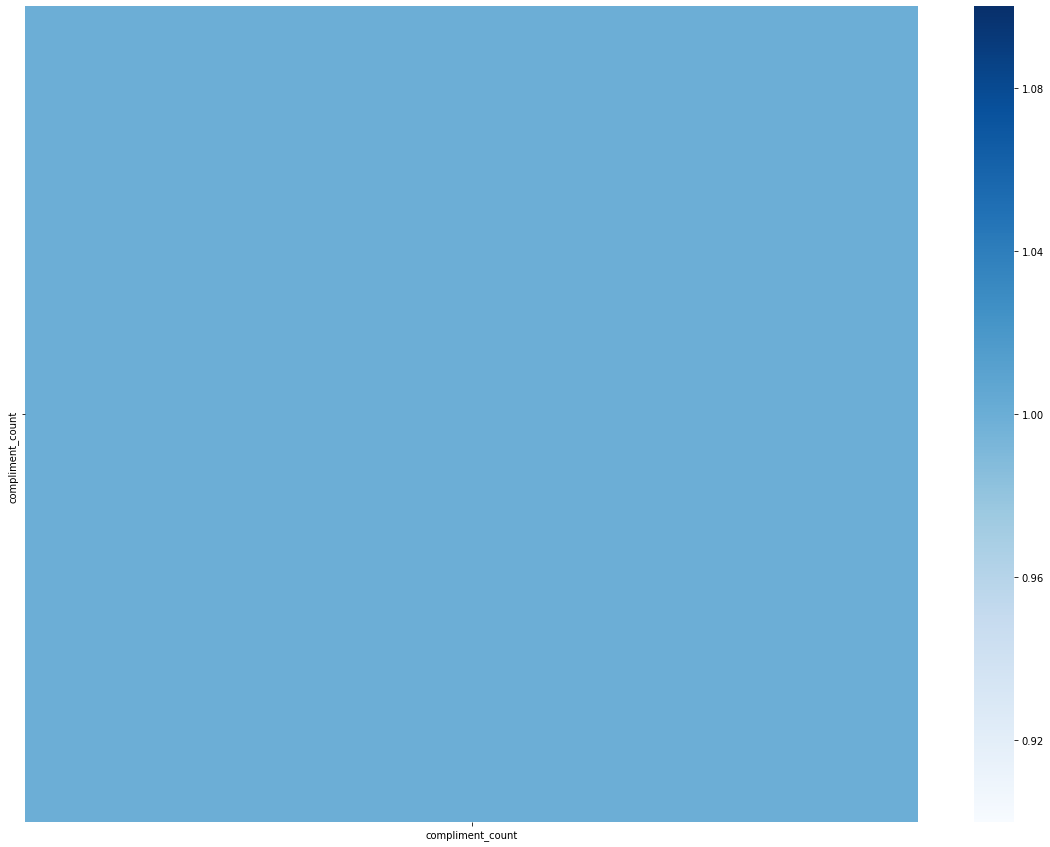

In [10]:
#Visualize correlations between quantitative vars
#variables that are strongly correleated will be removed during the feature selection process.
corr = tip_df.corr()
sns.heatmap(corr, cmap="Blues", 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

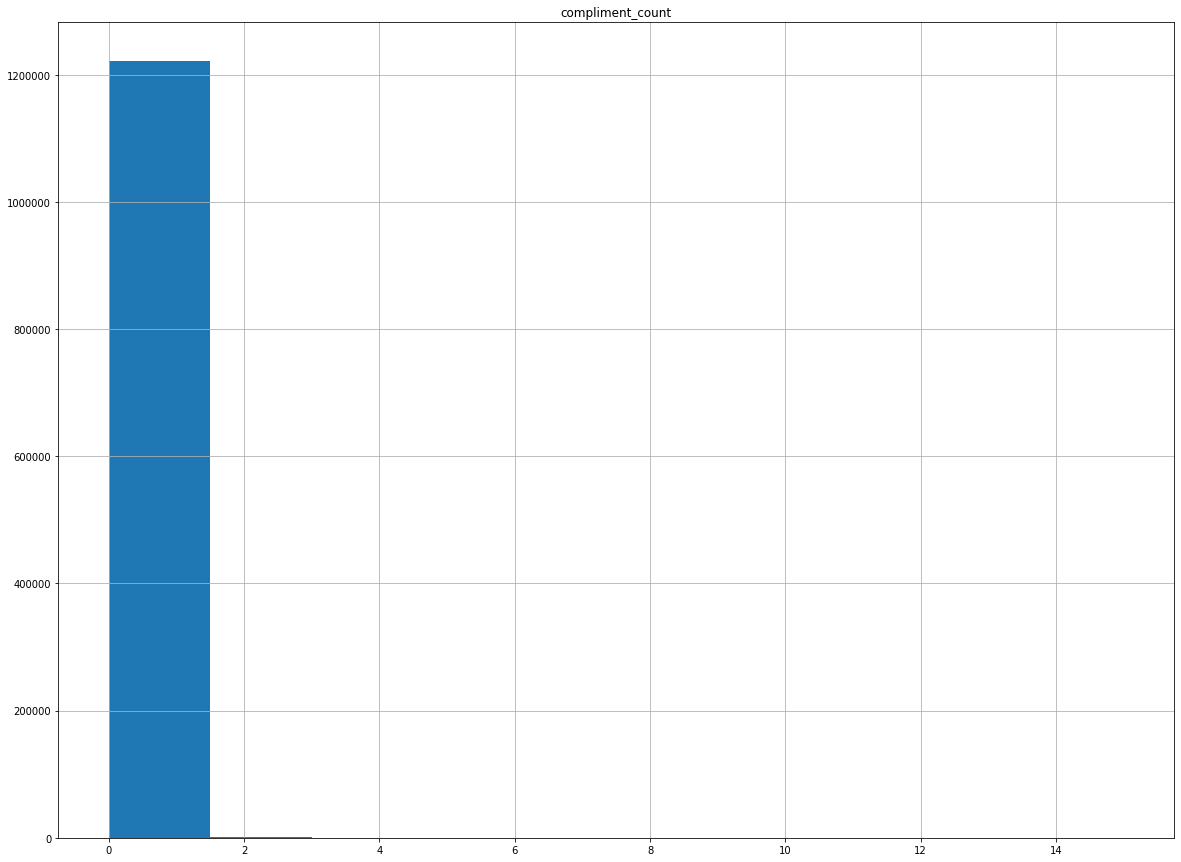

In [11]:
tip_df_num = tip_df.select_dtypes(include=np.number)


hist = tip_df_num.hist()
#Histograms don't really show much here because a lot of the fields are very close together with little spread.
#In addition, most values for these fields seem to be close to 0.
#However, it seems stars has a skewed to the left distribution (due to the peak at 5.0.

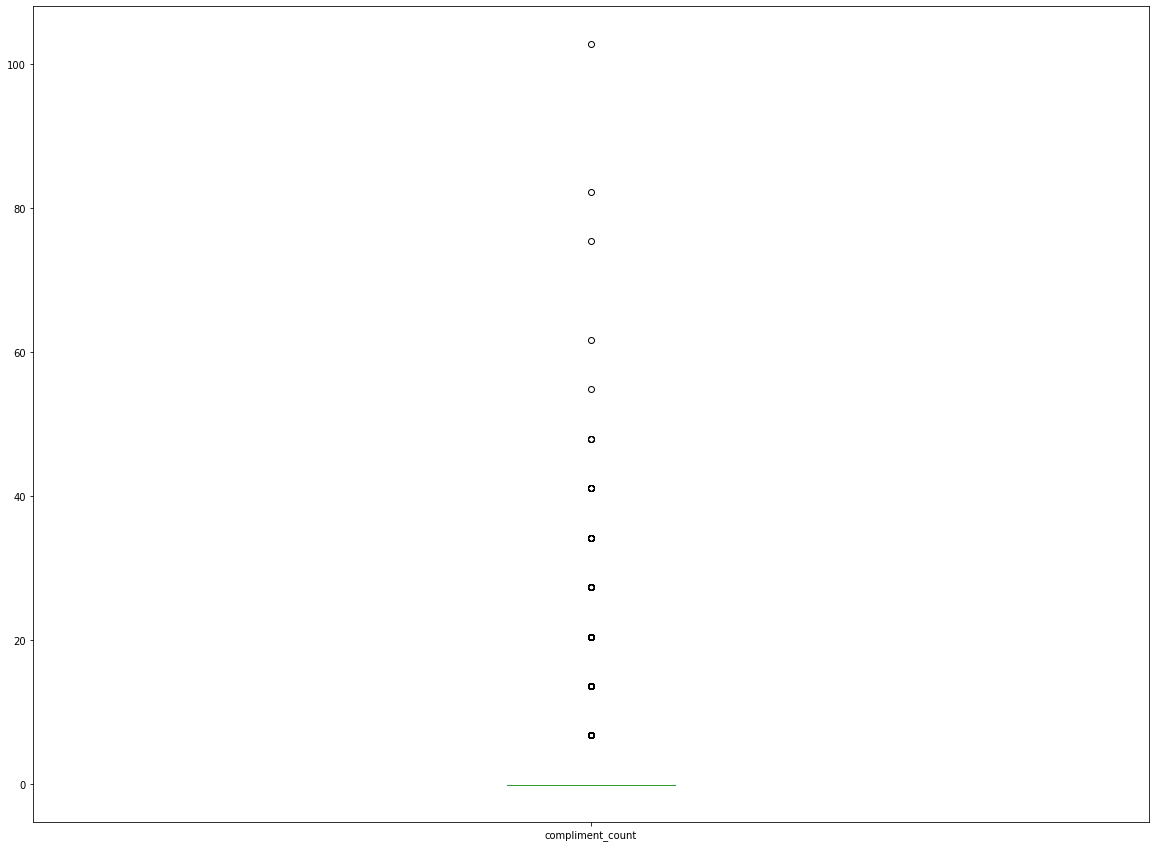

In [12]:
#Scale and center data to compare variance in side-by-side boxplots, and to easily spot outliers.
df_center = (tip_df_num - tip_df_num.mean())
df_scale = (df_center - df_center.mean())/df_center.std()
df_scale.plot.box()
#A lot of outlier and extremes. These will have to be treated prior to analysis.
#Stars seems to have low spread with no outliers, most likely because there is a max set by yelp.

In [13]:
#Clean up and save description csv.
#The plots can be obtained via screenshot.

#To make sure field names make it in output csv
row_labels = df_description_nulls.index.values
df_description_nulls.insert (0, "Field", row_labels)
df_to_csv(df_description_nulls, fp + "/tip_desc_nulls", ext=".csv", na_rep="")

row_labels = df_description_number.index.values
df_description_number.insert (0, "Param", row_labels)
df_to_csv(df_description_number, fp + "/tip_desc_number", ext=".csv", na_rep="")

row_labels = df_description_cat.index.values
df_description_cat.insert (0, "Param", row_labels)
df_to_csv(df_description_cat, fp + "/tip_desc_cat", ext=".csv", na_rep="")
tip_df = None
tip_df_num = None
tip_df_cat = None